In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read CSV into dataframe and preview
file_csv = "data/classify.csv"
classify_df = pd.read_csv(file_csv, encoding="ISO-8859-1")
classify_df.head()

,IsHoliday,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,NewMarkDown1,NewMarkDown2,NewMarkDown3,NewMarkDown4,NewMarkDown5
0,0,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1
1,0,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1
2,0,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1
3,0,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1
4,0,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1


In [3]:
classify_df.describe()

,IsHoliday,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,NewMarkDown1,NewMarkDown2,NewMarkDown3,NewMarkDown4,NewMarkDown5
count,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000,266496.000000
mean,0.078496,16181.632128,136420.296170,57.270697,3.625386,7412.884804,2603.157249,1689.409045,3000.199289,4324.021158,175.516298,7.221692,0.995846,0.734551,0.905879,0.889856,0.999490
std,0.268952,18123.316812,61110.965643,18.348916,0.271614,9405.340314,7895.430908,11089.699223,6568.140310,13549.262124,40.659001,1.688433,0.064317,0.441573,0.291998,0.313070,0.022585
min,0.000000,-1699.000000,34875.000000,-7.290000,2.872000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,129.816710,3.684000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5361.427500,93638.000000,43.540000,3.451000,2088.090000,0.000000,4.140000,124.180000,1570.112500,136.643258,6.143000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,0.000000,12260.705000,140167.000000,57.870000,3.629000,5097.870000,121.560000,29.770000,924.920000,2870.910000,189.707605,7.139000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.000000,20350.455290,202505.000000,71.560000,3.804000,9295.460000,1148.080000,143.880000,2996.470000,5012.220000,220.849847,8.239000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,649770.180000,219622.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,12.890000,1.000000,1.000000,1.000000,1.000000,1.000000


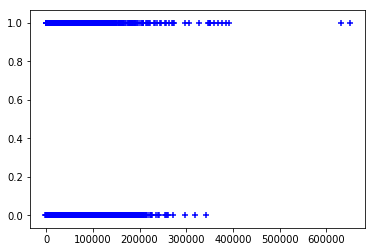

In [4]:
plt.scatter(classify_df.Weekly_Sales, classify_df.IsHoliday, marker='+',color='blue')

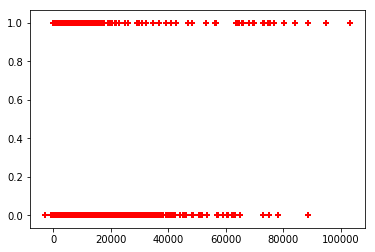

In [5]:
plt.scatter(classify_df.MarkDown1, classify_df.IsHoliday, marker='+',color='red')

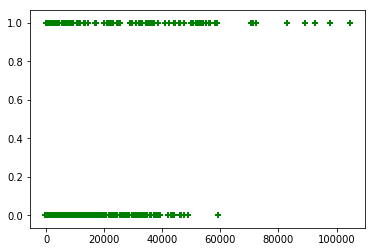

In [6]:
plt.scatter(classify_df.MarkDown2, classify_df.IsHoliday, marker='+',color='green')

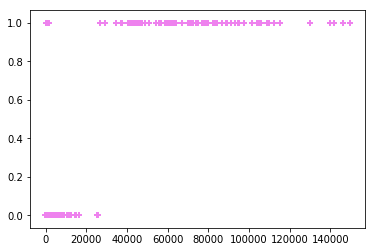

In [7]:
plt.scatter(classify_df.MarkDown3, classify_df.IsHoliday, marker='+',color='violet')

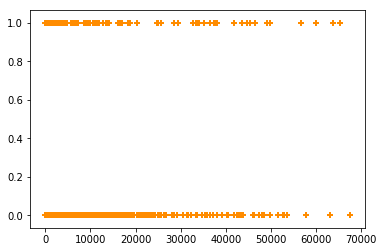

In [8]:
plt.scatter(classify_df.MarkDown4, classify_df.IsHoliday, marker='+',color='darkorange')

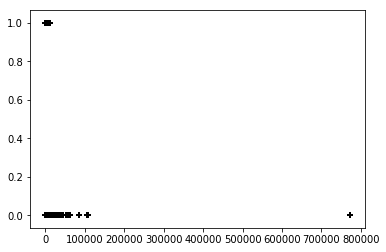

In [9]:
plt.scatter(classify_df.MarkDown5, classify_df.IsHoliday, marker='+',color='black')

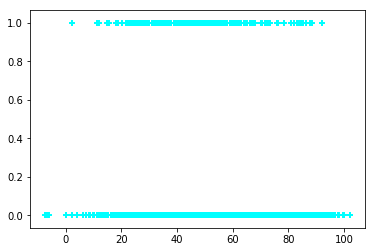

In [10]:
plt.scatter(classify_df.Temperature, classify_df.IsHoliday, marker='+',color='cyan')

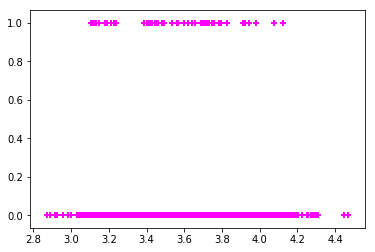

In [11]:
plt.scatter(classify_df.Fuel_Price, classify_df.IsHoliday, marker='+',color='Magenta')

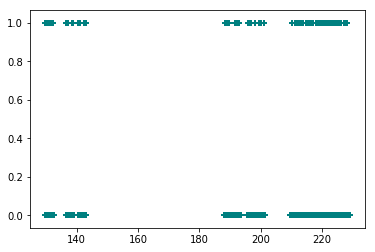

In [12]:
plt.scatter(classify_df.CPI, classify_df.IsHoliday, marker='+',color='Teal')

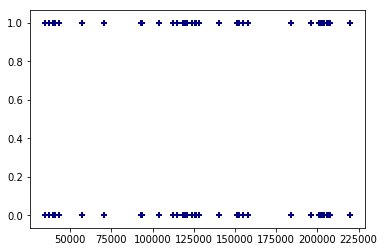

In [13]:
plt.scatter(classify_df.Size, classify_df.IsHoliday, marker='+',color='Navy')

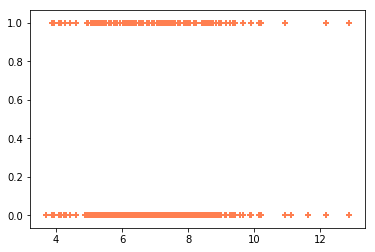

In [14]:
plt.scatter(classify_df.Unemployment, classify_df.IsHoliday, marker='+',color='coral')

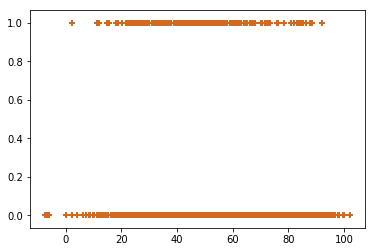

In [15]:
plt.scatter(classify_df.Temperature, classify_df.IsHoliday, marker='+',color='chocolate')

In [16]:
print(classify_df.dtypes)

IsHoliday         int64
Weekly_Sales    float64
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
NewMarkDown1      int64
NewMarkDown2      int64
NewMarkDown3      int64
NewMarkDown4      int64
NewMarkDown5      int64
dtype: object


In [40]:
len(classify_df)

266496

In [18]:
# Define features
X = classify_df.loc[:, classify_df.columns != 'IsHoliday']
X.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,NewMarkDown1,NewMarkDown2,NewMarkDown3,NewMarkDown4,NewMarkDown5
0,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1
1,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1
2,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1
3,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1
4,9137.035816,125833,66.36,3.451,1769.37,0.0,97.1,0.0,3594.24,228.976456,4.893,1,0,1,0,1


In [19]:
# Define target
y = classify_df['IsHoliday'].to_frame()
y.head()

,IsHoliday
0,0
1,0
2,0
3,0
4,0


In [20]:
# Count of target values
y['IsHoliday'].value_counts()

0    245577
1     20919
Name: IsHoliday, dtype: int64

In [21]:
# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

In [22]:
# 80/20 training and test split. Incorporate stratification to retain
# class distribution within the training and test sets.

X_train, X_test, y_train, y_test = train_test_split(
    X_standard,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42    
)

In [23]:
#  Train a logistic regression classifier on the training set using the default hyperparameter
# and evaluate its performance on the test set. 
# Classes are imbalanced---use F1 score performance metric.

classify = LogisticRegression()
classify.fit(X_train, y_train)
y_pred = classify.predict(X_test)
metrics.f1_score(y_test, y_pred)

0.5938339920948617

In [25]:
# Confirm this performance holds for other splits, tune the regularization hyperparameter. 
# Utilize nested cross-validation

param_grid = [{'C': np.logspace(-3, 3, 10)}]

grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    scoring='f1',
    n_jobs=-1
)

scores = cross_val_score(
    estimator=grid_search,
    X=X_standard,
    y=y,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    scoring='f1',
    n_jobs=-1
)

In [26]:
scores

array([0.59522313, 0.59179471, 0.59123506, 0.59869779, 0.59497645,
       0.59133226, 0.58699473, 0.5858007 , 0.59055244, 0.59245103])

In [27]:
scores.mean()

0.5919058304352444

In [29]:
# Perform grid search to identify the optimal regularization hyperparameter.

grid_search.fit(X_standard, y)
grid_search.best_params_

{'C': 215.44346900318823}

In [30]:
# train the final model
final_classify = LogisticRegression(C=0.1)
final_classify.fit(X_standard, y);

In [32]:
# report the five features that are most strongly correlated with class
feature_ranks = pd.DataFrame(final_classify.coef_, index=['parameter value'])
feature_ranks.columns = X.columns

# Strongest five positive
feature_ranks.sort_values('parameter value', axis=1, ascending=False).T.head()

,parameter value
MarkDown3,1.862143
MarkDown2,0.723529
MarkDown1,0.692277
Unemployment,0.144935
NewMarkDown2,0.143033


In [33]:
# Strongest five negative
feature_ranks.sort_values('parameter value', axis=1, ascending=True).T.head()

,parameter value
MarkDown5,-1.459143
Size,-0.640652
Fuel_Price,-0.295247
Temperature,-0.068449
Weekly_Sales,-0.025376


In [34]:
print(confusion_matrix(y_test,y_pred))

[[48853   263]
 [ 2306  1878]]


In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     49116
           1       0.88      0.45      0.59      4184

   micro avg       0.95      0.95      0.95     53300
   macro avg       0.92      0.72      0.78     53300
weighted avg       0.95      0.95      0.94     53300



In [36]:
confusion_df = pd.DataFrame(data=confusion_matrix(y_test,y_pred),columns=['Predicted No', 'Predicted Yes'])
print(confusion_df)

   Predicted No  Predicted Yes
0         48853            263
1          2306           1878


In [37]:
MAE = mean_absolute_error(y_test,y_pred)
print(MAE)

0.048198874296435275
